# <center> Time series segmentation и Data Shifts</center>

## Что это? 

Еще одна из задач, возникающая с временными рядами, - сегментация и поиск точек "перелома", в которых временной ряд начинает вести себя не так, как раньше. 

<img src="pictures/segments.png" width=600>

## Зачем? 

Сегментация может внезапно возникать в самых разных ситуациях:
- Поиск аномального изменения временного ряда, например, при считывании показателей датчиков, анализа трафика в сети
- Поиск "интересных" сегментов во временном ряду, например, активности в данных акселерометра, нестандартных участком геномных последовательностей
- Извлечение дополнительных признаков из временного ряда - сколько раз изменялась структура, сколько разных состояний было
- И наверняка еще много примеров, но вот так сразу в голову пришли вот эти три :)

# <center> Типы изменений во временных рядах </center>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
x1 = np.arange(0, 50, 0.1)
x2 = np.arange(50, 100, 0.1)

## Структурный сдвиг / location shift

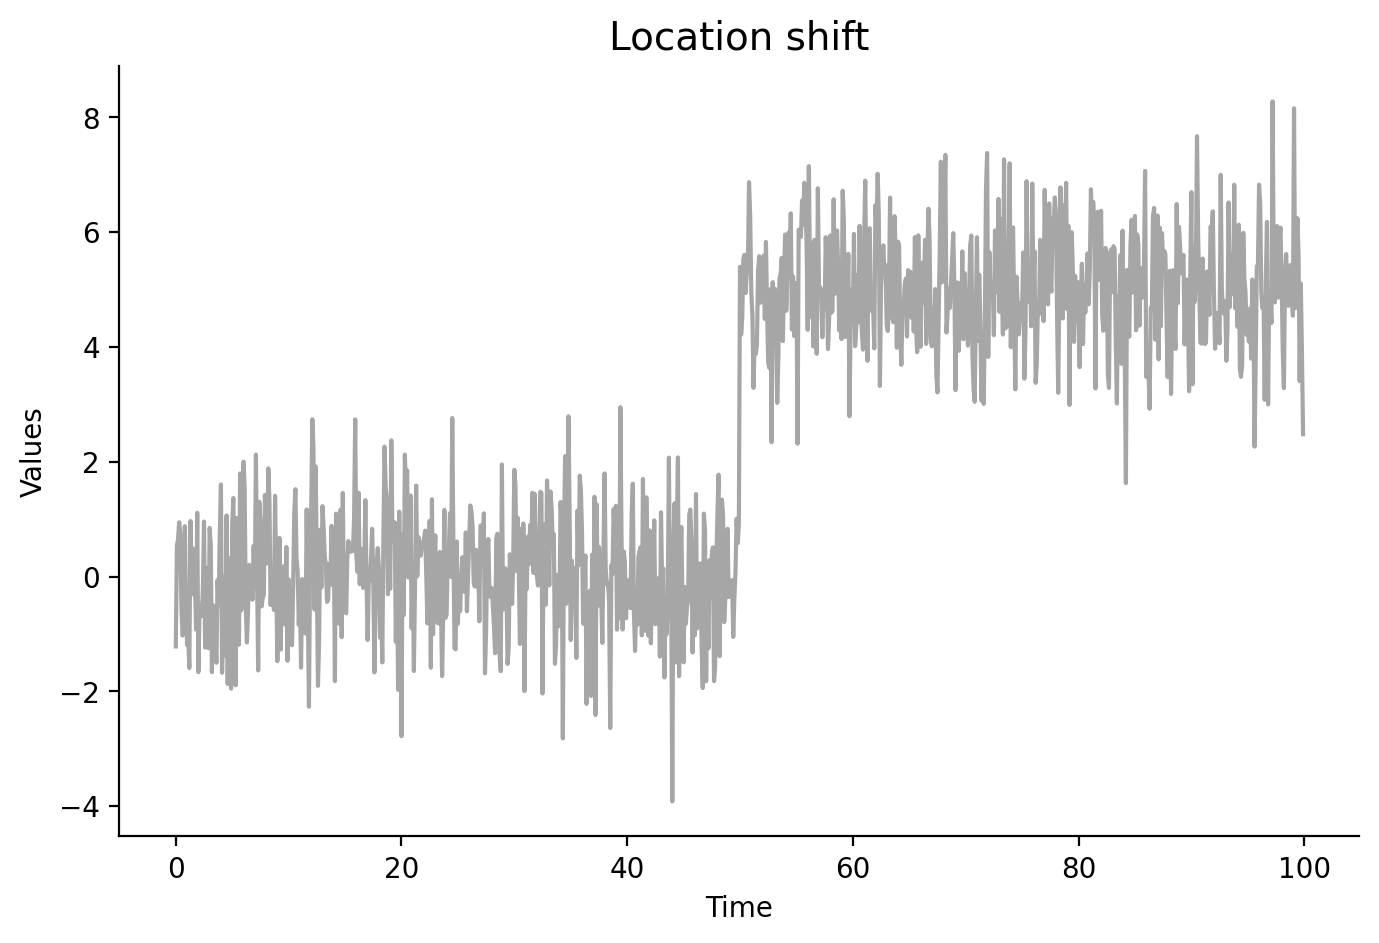

In [3]:
location_shift =  np.concatenate((
  np.random.normal(loc=0.0, size=len(x1)), 
  np.random.normal(loc=5.0, size=len(x2))
))

plt.figure(figsize=(8, 5))
plt.plot(
    np.concatenate((x1, x2)), 
    location_shift,
    color='grey',
    alpha=0.7
)
sns.despine()
plt.title("Location shift", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

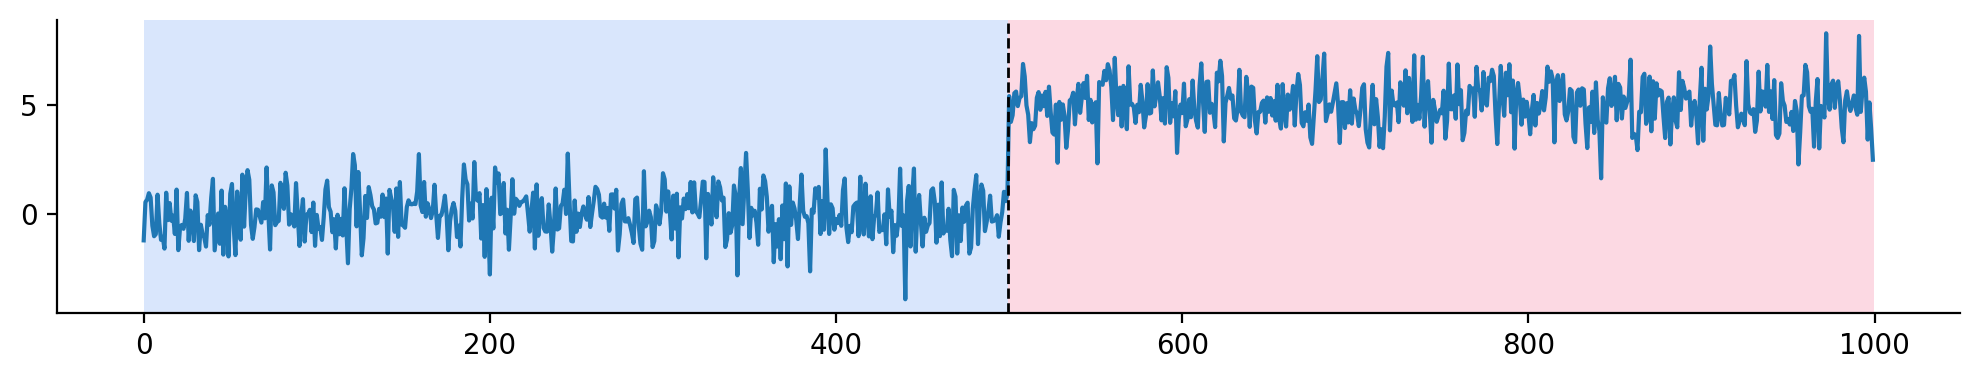

In [4]:
algo = rpt.Pelt(model="rbf").fit(location_shift)
result = algo.predict(pen=2)

rpt.display(location_shift, result, result, computed_chg_pts_linewidth=1)
sns.despine()
plt.show()

## Изменение дисперсии (кластеры волатильности) / scale shift

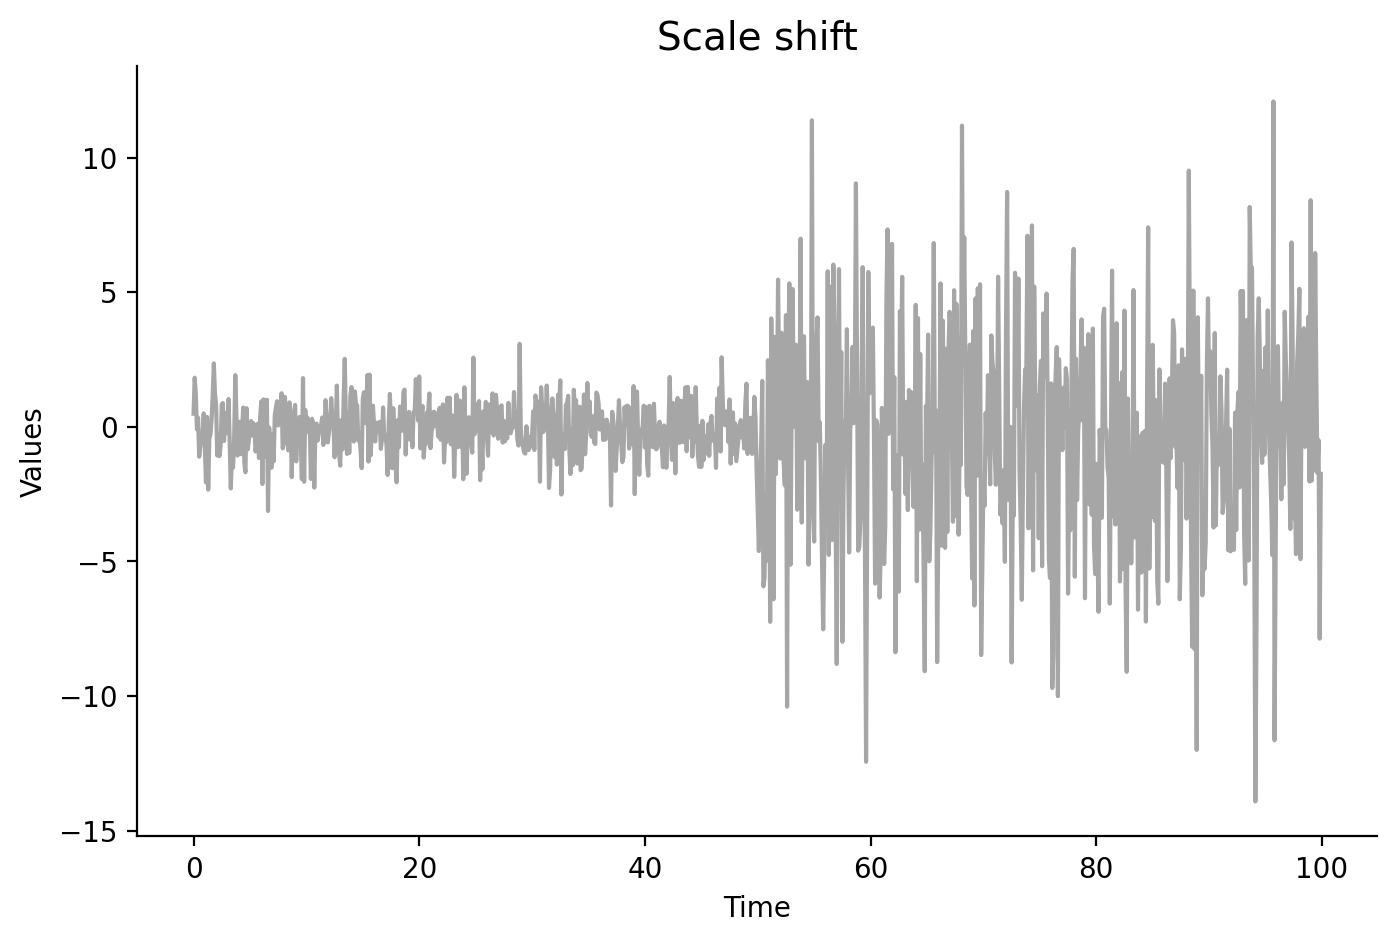

In [5]:
scale_shift = np.concatenate((
  np.random.normal(loc=0.0, scale=1.0, size=len(x1)), 
  np.random.normal(loc=0.0, scale=4.0, size=len(x2))
))

plt.figure(figsize=(8, 5))
plt.plot(
    np.concatenate((x1, x2)), 
    scale_shift,
    color='grey',
    alpha=0.7
)
sns.despine()
plt.title("Scale shift", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

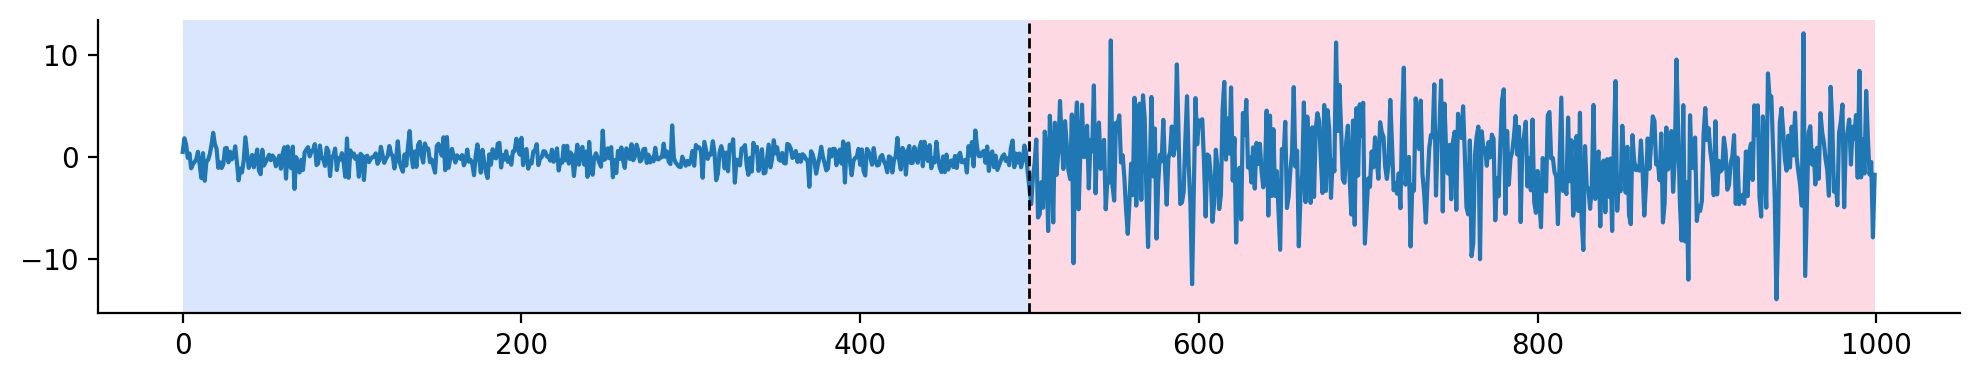

In [6]:
algo = rpt.Pelt(model="rbf").fit(scale_shift)
result = algo.predict(pen=3)

rpt.display(scale_shift, result, result, computed_chg_pts_linewidth=1)
sns.despine()
plt.show()

## Изменение сезонности / seasonality shift

https://anomaly.io/change-point-detection-seasonal/index.html

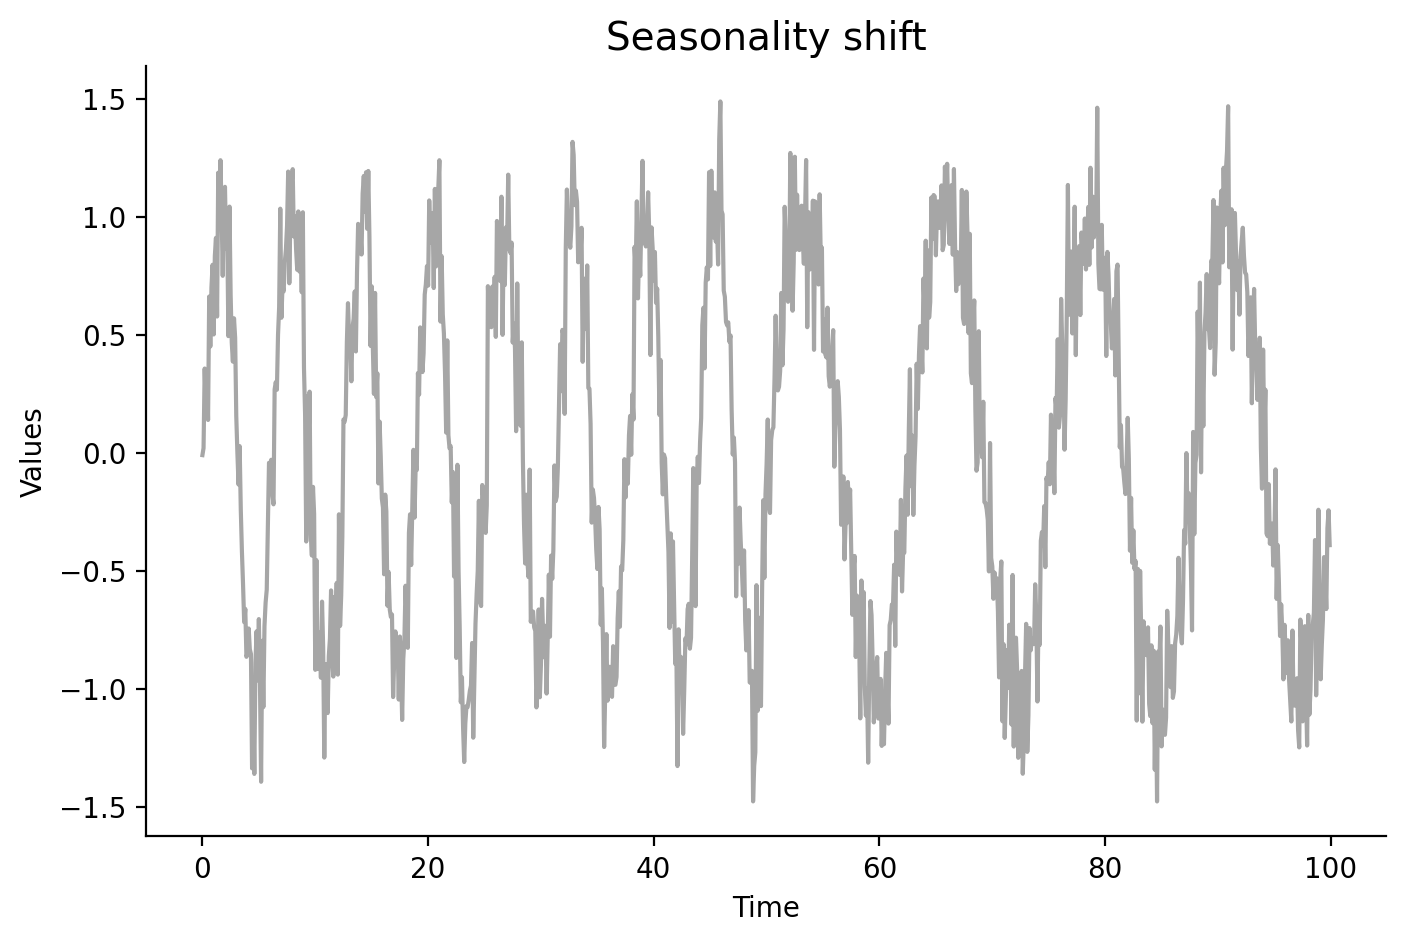

In [7]:
seasonality_shift = np.concatenate((
  np.sin(x1) + np.random.normal(loc=0.0, scale=.2, size=len(x1)), 
  np.sin(x2/2) + np.random.normal(loc=0.0, scale=.2, size=len(x2)))
)

plt.figure(figsize=(8, 5))
plt.plot(
  np.concatenate((x1, x2)), 
  seasonality_shift,
  color='grey',
  alpha=0.7
)

sns.despine()
plt.title("Seasonality shift", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

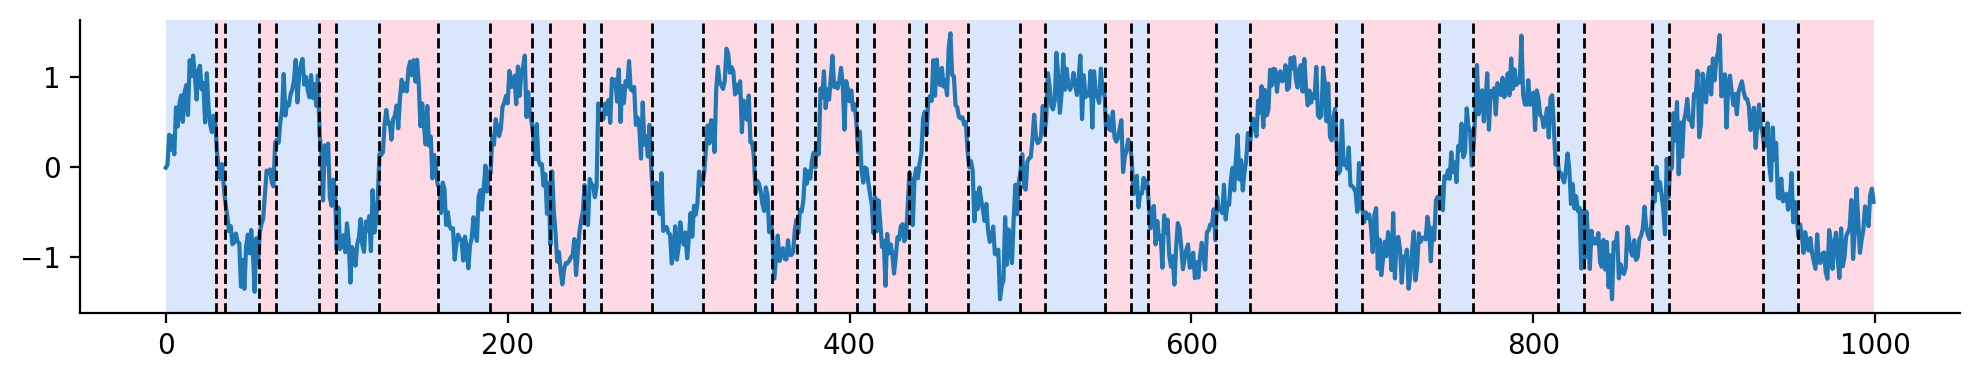

In [8]:
algo = rpt.Pelt(model="rbf").fit(seasonality_shift)
result = algo.predict(pen=3)

rpt.display(seasonality_shift, result, result, computed_chg_pts_linewidth=1)
sns.despine()
plt.show()

## Живые данные

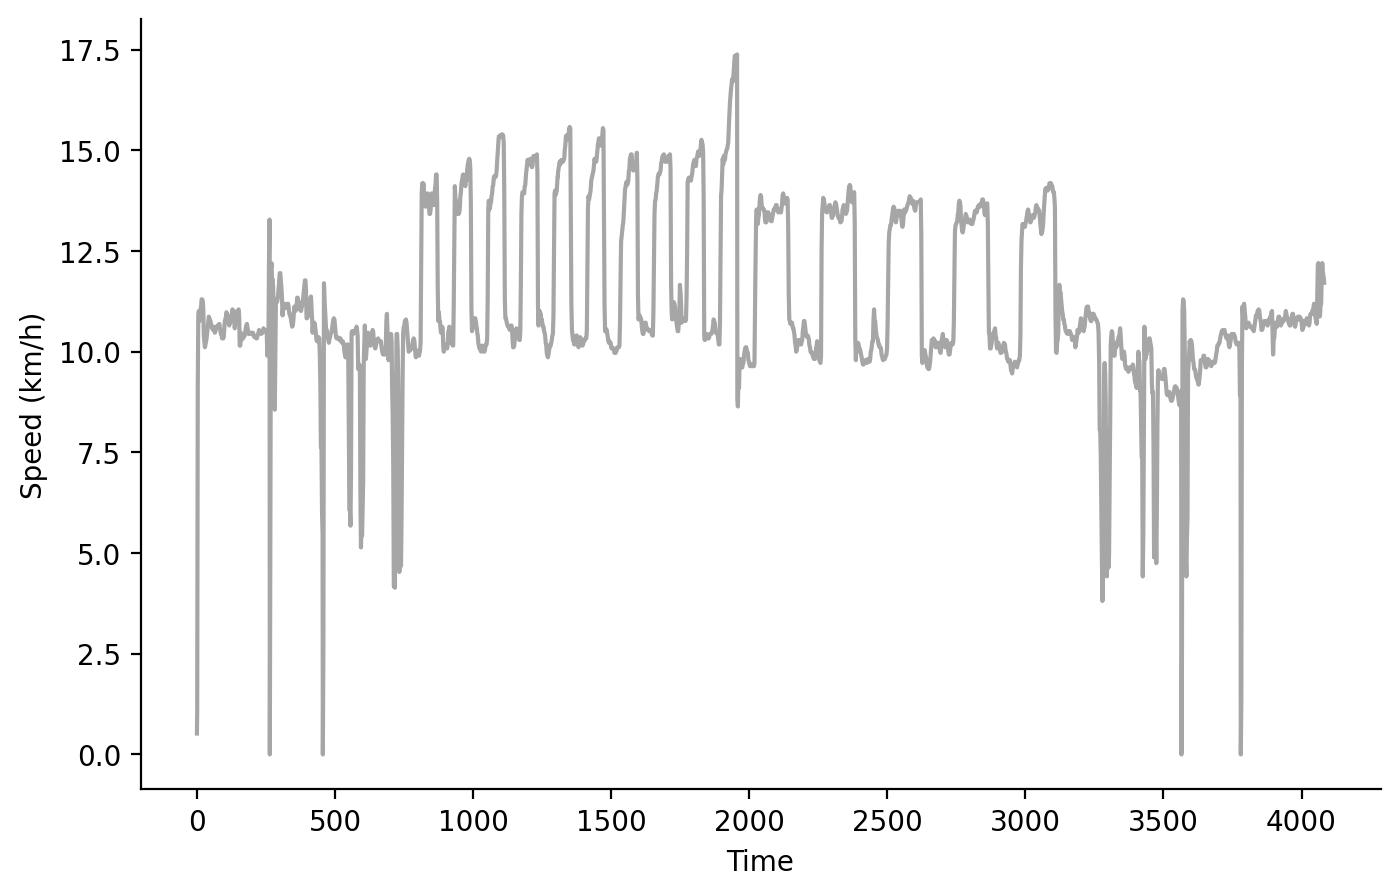

In [15]:
df = pd.read_csv('data/speed.csv')

plt.figure(figsize=(8, 5))
plt.plot(
  range(df.shape[0]), 
  df,
  color='grey',
  alpha=0.7
)
sns.despine()
plt.ylabel('Speed (km/h)')
plt.xlabel('Time')
plt.show()

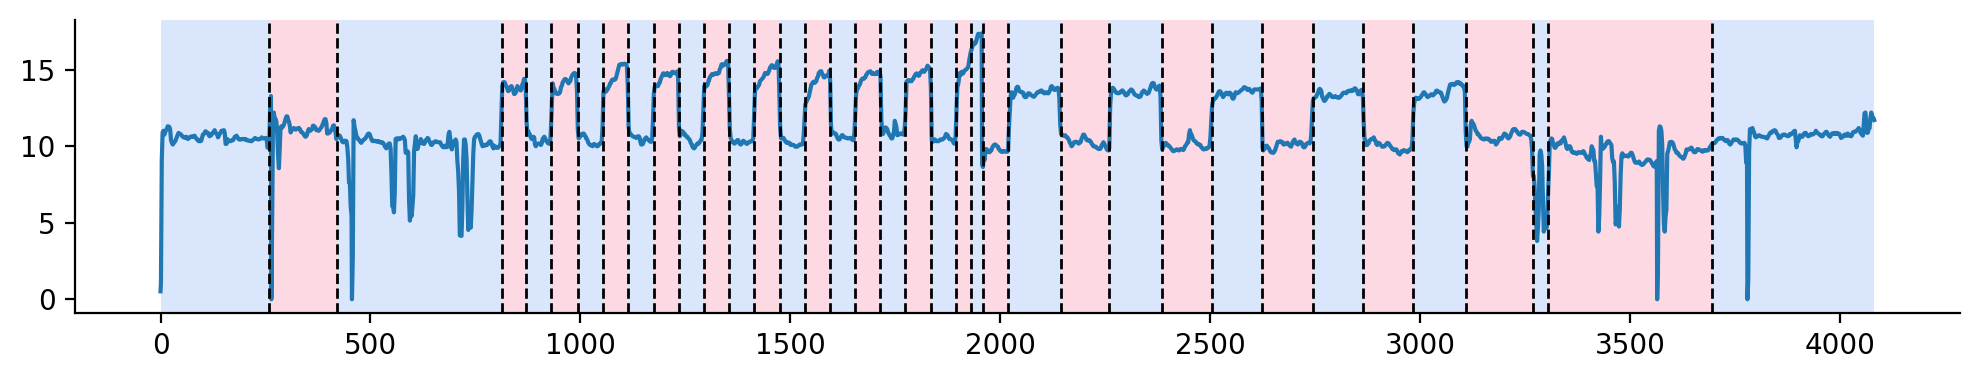

In [16]:
algo = rpt.Pelt(model="rbf").fit(df)
result = algo.predict(pen=15)

rpt.display(df, result, result, computed_chg_pts_linewidth=1)
sns.despine()
plt.show()

[Ссылка на оригинальную статью](https://arxiv.org/pdf/1101.1438)

Основные шаги алгоритма такие же, как и в методе оптимального разделения(optimal partitioning, Jackson et al., 2005) - мы устанавливаем функцию "стоимости" для сегмента, затем перебираем все возможные начальные / конечные точки сегмента и проверяем, даёт ли разделение на новые сегменты уменьшение значения функции стоимости по сравнению с сегментом без разделения.

Общая форма функции потерь:

<img src='pictures/cost_function.png' width=300>

где $C$ - функция стоимости сегмента, $\tau_i$ - changepoint, $m$ - общее количество точек изменения, $\beta$ - регуляризатор (penalty) для предотвращения оверфита

Итак, мы пытаемся найти такое множество разбиения $\tau$ из $m$ точек, которое приведет к наименьшей сумме стоимостей сегментов.

В исходном алгоритме оптимального разделения, который не использует прунинг, задача минимизации итеративно решается с помощью рекурсии. Можно показать, что стоимость оптимальной сегментации шага t + 1 зависит от стоимости оптимальной сегментации шага t (при этом стоимость сегментации шага 0 просто установлена равной -β).

На каждой итерации t алгоритм пытается найти точку перехода между текущей точкой и концом ряда. Для этого он вычисляет функции стоимостей возможных разделов [(start, start + 1), (start, start + 2),…, (start, n-1)], проверяет, дают ли новый локальный минимум какое-либо из разбиений, сумированное со стоимостью всех предыдущих разбивок и регуляризации, и если да, то алгоритм добавляет позицию точки изменения к кандидатам.

Все начинается в точке 0, где стоимость разделения - это, по сути, стоимость одного большого сегмента - полного временного ряда. Затем алгоритм начинает итерацию от точки 1 до конца временного ряда, каждый раз вычисляя стоимость разделения. В конце концов, он находит такую точку, которая минимизирует итоговую стоимость разделения, и запоминает ее. Обратите внимание, что эта точка может лежать в диапазоне от 1 до n-1, где n - длина ряда. Найдя такую точку, алгоритм затем продолжает поиск с новой начальной точки, снова идет до конца ряда, вычисляет стоимость разделения, но на этот раз он использует уже рассчитанную оптимальную стоимость разделения из предыдущего шага. Операция повторяется до тех пор, пока не будут проверены все потенциальные отправные точки.

Как это выглядит после тестирования всех начальных точек: на верхнем графике указана стоимость разделения в момент времени t, учитывая, что предыдущие точки уже были оптимально разделены.

Можно заметить, что начальная точка 0 имеет наивысшую стоимость, то есть, по сути, это стоимость полного несегментированного временного ряда. Затем у нас есть первая оптимальная точка разделения около 120. Кстати, если бы регуляризация была ниже, алгоритм также установил бы точку разделения около 100 (время пробуждения). Все последующие точки разделения также уменьшают общую стоимость.

## Как? 

**Основная идея** - задать некоторую функцию "похожести" кусков временного ряда друг на друга. Различия методов будут происходить от разных вариантов задания функций и разных способов определения кусков :) 

Важное разделение - онлайн/оффлайн алгоритмы.

### Онлайн алгоритмы:
- Сегментируют ряд по мере поступления его новых значений
- Результаты сегментации в прошлом не могут изменяться в зависимости от новых наблюдений
- Обычно приближенная (approximate) сегментация

### Оффлайн алгоритмы:
- Работают со всем временным рядом сразу
- Результаты исторической сегментации могут измениться, если мы добавим новые значения 
- Обычно точная (exact) сегментация

Однако на практике оффлайн методы иногда неплохо заходят в онлайн сценариях ¯\\_(ツ)_/¯